In [187]:
from sklearn.preprocessing import OneHotEncoder
#

enc = OneHotEncoder(categories=[[2019, 2020, 2021, 2022, 2023],
                                ['m', 'n', 'r'], ], sparse=False, handle_unknown='ignore')
enc.fit_transform([[2019, 'm'],
                   [2022, 'n'],
                   [2023, 'r']])

# ans = enc.transform([[0, 2, 3]]).toarray()
# print(ans)  # 输出 [[ 1.  0.  0.  0.  1.  0.  0.  0.  1.]]

array([[1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.]])

In [189]:
enc.get_feature_names()

array(['x0_2019', 'x0_2020', 'x0_2021', 'x0_2022', 'x0_2023', 'x1_m',
       'x1_n', 'x1_r'], dtype=object)

In [107]:
enc.categories_

[array([2019, 2020, 2021, 2022, 2023]), array([2019, 2020, 2021, 2022, 2023])]

In [346]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
import torch.nn as nn
import lightgbm as lgb
from utils import *
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [31]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [327]:
alldata = data[(data.asin == 'B07T1CH2HH')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(624, 2)

In [355]:
np.correlate([1, 2, 3], [1, 2, 3])

array([14])

In [356]:
np.dot([1, 2, 3], [1, 2, 3])

14

In [352]:
np.cov([1, 2, 3], [3, 2, 1])

array([[ 1., -1.],
       [-1.,  1.]])

In [331]:
alldata.ordered_units

15972    865
15934    259
15900    261
15866    260
15834    263
        ... 
28726    133
28606    144
28545    155
28665    146
28847    187
Name: ordered_units, Length: 624, dtype: int64

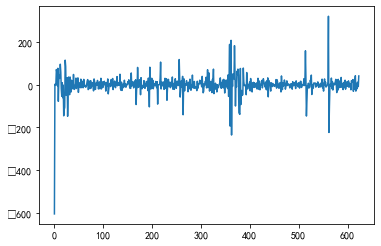

In [334]:
plt.plot(alldata.ordered_units.diff(1).values)

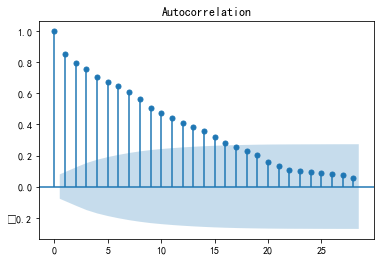

In [357]:
plot_acf(alldata.ordered_units).show()

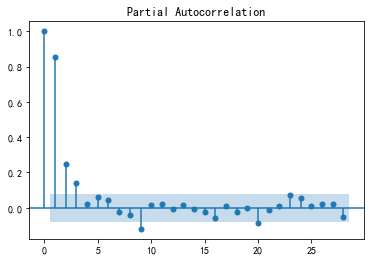

In [358]:
plot_pacf(alldata.ordered_units).show()

平稳性检验

In [359]:
from statsmodels.tsa.stattools import adfuller

In [364]:
print(adfuller(alldata.ordered_units, 1))

(-4.959748261782083, 2.664525099724574e-05, 1, 622, {'1%': -3.4409070618215996, '5%': -2.8661978948030686, '10%': -2.569250572471335}, 6308.680695591702)


In [366]:
print(adfuller(np.random.randn(10,), 1))

(-3.0788499807160106, 0.02815849544111403, 1, 8, {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}, 26.18685801591194)


统计量小于三种置信度且p值接近于0，则拒绝原假设

白噪声检验

In [381]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

In [373]:
alldata = alldata.set_index('data_date')

In [406]:
train = alldata.truncate(after='2021-7-21')
test = alldata.truncate(before='2021-7-22')

In [407]:
train.head(2).append(train.tail(2))

,ordered_units
data_date,
2019-12-02,865
2019-12-03,259
2021-07-20,94
2021-07-21,71


In [408]:
test.head(2).append(test.tail(2))

,ordered_units
data_date,
2021-07-22,80
2021-07-23,66
2021-08-21,146
2021-08-22,187


In [399]:
train1 = train.reset_index()
train1

,data_date,ordered_units
0,2019-12-02,865
1,2019-12-03,259
2,2019-12-04,261
3,2019-12-05,260
4,2019-12-06,263
...,...,...
587,2021-07-17,113
588,2021-07-18,103
589,2021-07-19,109
590,2021-07-20,94


In [425]:
arima_model = ARIMA(train, order=(1, 0, 1))

In [426]:
result = arima_model.fit()

In [432]:
pred = result.predict('2019-12-10', '2019-12-30', dynamic=True)

In [436]:
a = np.array([2, 3, 4, 3, 7])

In [437]:
a.mean()

3.8

In [443]:
a = pd.Series(np.random.randn(100), index=pd.date_range('2019-12-02', periods=100))

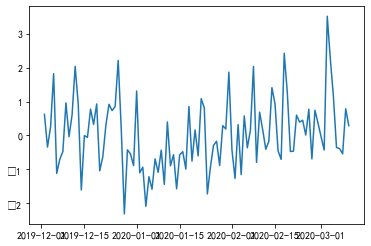

In [444]:
plt.plot(a)

In [441]:
pd.DataFrame({'ds':pd.date_range('2019-10-21', periods=30,)})

,ds
0,2019-10-21
1,2019-10-22
2,2019-10-23
3,2019-10-24
4,2019-10-25
5,2019-10-26
6,2019-10-27
7,2019-10-28
8,2019-10-29
9,2019-10-30


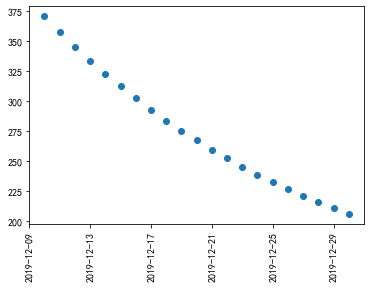

In [433]:
plt.xticks(rotation=90)
plt.scatter(pred.index, pred.values)

In [409]:
arima_model.predict(test)

NotImplementedError: 

In [379]:
alldata

,ordered_units
data_date,
2019-12-02,865
2019-12-03,259
2019-12-04,261
2019-12-05,260
2019-12-06,263
...,...
2021-08-18,133
2021-08-19,144
2021-08-20,155


In [370]:
acorr_ljungbox(alldata.ordered_units, lags=1)

(array([455.07071782]), array([0.]))

In [4]:
alldata.head(2).append(alldata.tail(2))

,data_date,ordered_units
15972,2019-12-02,865
15934,2019-12-03,259
28665,2021-08-21,146
28847,2021-08-22,187


In [33]:
pd.date_range('2019-12-2', '2021-8-22').shape

(630,)

2019-12-2到2021-8-22一共是630天的数据，所以这里少了6天的数据

In [34]:
# 缺少了多少天的数据
set(pd.date_range('2019-12-2', '2021-8-22')).difference(set(alldata.data_date))

{Timestamp('2020-06-15 00:00:00', freq='D'),
 Timestamp('2020-07-03 00:00:00', freq='D'),
 Timestamp('2021-01-27 00:00:00', freq='D'),
 Timestamp('2021-01-31 00:00:00', freq='D'),
 Timestamp('2021-02-01 00:00:00', freq='D'),
 Timestamp('2021-02-03 00:00:00', freq='D')}

In [35]:
# 每天的平均销量
alldata.mean()

ordered_units   117.0705
dtype: float64

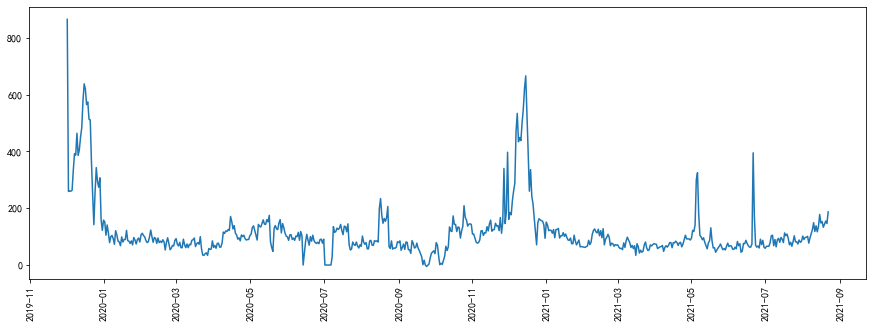

In [36]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

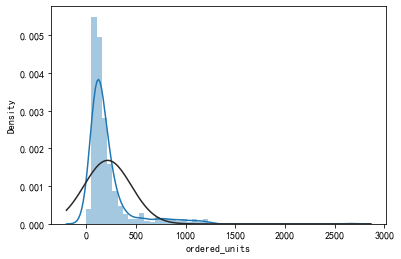

In [8]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [7]:
alldata.ordered_units.skew(), np.log1p(alldata.ordered_units).skew()

(7.5340006644908195, -3.616558075453425)

In [8]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

0.022899662729770277

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

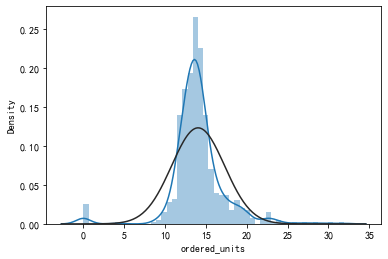

In [10]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [37]:
alldata[alldata.ordered_units <= 0].index

Int64Index([8943, 8240, 8162, 8123, 8081, 8042, 4878, 4835, 4791], dtype='int64')

In [38]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

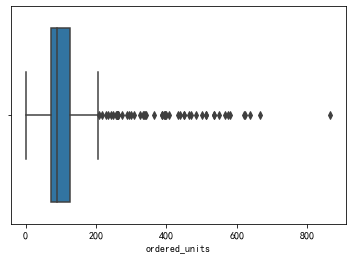

In [39]:
sns.boxplot(alldata.ordered_units)

In [40]:
alldata[alldata.ordered_units > 700].index

Int64Index([15972], dtype='int64')

In [42]:
alldata.drop(alldata[alldata.ordered_units > 700].index, inplace=True)

In [43]:
alldata.shape

(614, 2)

### 设置样本权重

In [45]:
alldata['weight'] = alldata.data_date.apply(lambda x: (
    x - pd.to_datetime('2019-12-02')).days)

In [46]:
alldata.head(1)

,data_date,ordered_units,weight
15934,2019-12-03,259,1


### 缺失值

In [47]:
alldata.isnull().sum()

data_date        0
ordered_units    0
weight           0
dtype: int64

无缺失值不用处理

### 创造特征

In [48]:
def create_feature(df):
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [49]:
alldata = create_feature(alldata)

In [299]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15934,259,1,2019,12,3,1,4,49
15900,261,2,2019,12,4,2,4,49
15866,260,3,2019,12,5,3,4,49


In [300]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=0, shuffle=False)

In [301]:
x_train.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
15934,1,2019,12,3,1,4,49
15900,2,2019,12,4,2,4,49


### 编码

In [302]:
weight_cat = list(range(1, 1000))
year_category = [2019, 2020, 2021, 2022]
month_category = list(range(1, 13))
day_category = list(range(1, 32))
weekday_cat = sorted(x_train.weekday.unique())
quarter_cat = [1, 2, 3, 4]
weekofyear_cat = sorted(x_train.weekofyear.unique())

In [303]:
encoder = OneHotEncoder(sparse=False,
                        categories=[weight_cat, year_category, month_category,
                                    day_category, weekday_cat, quarter_cat, weekofyear_cat],
                        handle_unknown='ignore')
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((552, 1110), (62, 1110))

In [304]:
x_train = pd.DataFrame(x_train, columns=encoder.get_feature_names())
x_test = pd.DataFrame(x_test, columns=encoder.get_feature_names())
x_train.head(1)

,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19,x0_20,x0_21,x0_22,x0_23,x0_24,x0_25,x0_26,x0_27,x0_28,x0_29,x0_30,x0_31,x0_32,x0_33,x0_34,x0_35,x0_36,x0_37,x0_38,x0_39,x0_40,x0_41,x0_42,x0_43,x0_44,x0_45,x0_46,x0_47,x0_48,x0_49,x0_50,x0_51,x0_52,x0_53,x0_54,x0_55,x0_56,x0_57,x0_58,x0_59,x0_60,x0_61,x0_62,x0_63,x0_64,x0_65,x0_66,x0_67,x0_68,x0_69,x0_70,x0_71,x0_72,x0_73,x0_74,x0_75,x0_76,x0_77,x0_78,x0_79,x0_80,x0_81,x0_82,x0_83,x0_84,x0_85,x0_86,x0_87,x0_88,x0_89,x0_90,x0_91,x0_92,x0_93,x0_94,x0_95,x0_96,x0_97,x0_98,x0_99,x0_100,x0_101,x0_102,x0_103,x0_104,x0_105,x0_106,x0_107,x0_108,x0_109,x0_110,x0_111,x0_112,x0_113,x0_114,x0_115,x0_116,x0_117,x0_118,x0_119,x0_120,x0_121,x0_122,x0_123,x0_124,x0_125,x0_126,x0_127,x0_128,x0_129,x0_130,x0_131,x0_132,x0_133,x0_134,x0_135,x0_136,x0_137,x0_138,x0_139,x0_140,x0_141,x0_142,x0_143,x0_144,x0_145,x0_146,x0_147,x0_148,x0_149,x0_150,x0_151,x0_152,x0_153,x0_154,x0_155,x0_156,x0_157,x0_158,x0_159,x0_160,x0_161,x0_162,x0_163,x0_164,x0_165,x0_166,x0_167,x0_168,x0_169,x0_170,x0_171,x0_172,x0_173,x0_174,x0_175,x0_176,x0_177,x0_178,x0_179,x0_180,x0_181,x0_182,x0_183,x0_184,x0_185,x0_186,x0_187,x0_188,x0_189,x0_190,x0_191,x0_192,x0_193,x0_194,x0_195,x0_196,x0_197,x0_198,x0_199,x0_200,x0_201,x0_202,x0_203,x0_204,x0_205,x0_206,x0_207,x0_208,x0_209,x0_210,x0_211,x0_212,x0_213,x0_214,x0_215,x0_216,x0_217,x0_218,x0_219,x0_220,x0_221,x0_222,x0_223,x0_224,x0_225,x0_226,x0_227,x0_228,x0_229,x0_230,x0_231,x0_232,x0_233,x0_234,x0_235,x0_236,x0_237,x0_238,x0_239,x0_240,x0_241,x0_242,x0_243,x0_244,x0_245,x0_246,x0_247,x0_248,x0_249,x0_250,x0_251,x0_252,x0_253,x0_254,x0_255,x0_256,x0_257,x0_258,x0_259,x0_260,x0_261,x0_262,x0_263,x0_264,x0_265,x0_266,x0_267,x0_268,x0_269,x0_270,x0_271,x0_272,x0_273,x0_274,x0_275,x0_276,x0_277,x0_278,x0_279,x0_280,x0_281,x0_282,x0_283,x0_284,x0_285,x0_286,x0_287,x0_288,x0_289,x0_290,x0_291,x0_292,x0_293,x0_294,x0_295,x0_296,x0_297,x0_298,x0_299,x0_300,x0_301,x0_302,x0_303,x0_304,x0_305,x0_306,x0_307,x0_308,x0_309,x0_310,x0_311,x0_312,x0_313,x0_314,x0_315,x0_316,x0_317,x0_318,x0_319,x0_320,x0_321,x0_322,x0_323,x0_324,x0_325,x0_326,x0_327,x0_328,x0_329,x0_330,x0_331,x0_332,x0_333,x0_334,x0_335,x0_336,x0_337,x0_338,x0_339,x0_340,x0_341,x0_342,x0_343,x0_344,x0_345,x0_346,x0_347,x0_348,x0_349,x0_350,x0_351,x0_352,x0_353,x0_354,x0_355,x0_356,x0_357,x0_358,x0_359,x0_360,x0_361,x0_362,x0_363,x0_364,x0_365,x0_366,x0_367,x0_368,x0_369,x0_370,x0_371,x0_372,x0_373,x0_374,x0_375,x0_376,x0_377,x0_378,x0_379,x0_380,x0_381,x0_382,x0_383,x0_384,x0_385,x0_386,x0_387,x0_388,x0_389,x0_390,x0_391,x0_392,x0_393,x0_394,x0_395,x0_396,x0_397,x0_398,x0_399,x0_400,x0_401,x0_402,x0_403,x0_404,x0_405,x0_406,x0_407,x0_408,x0_409,x0_410,x0_411,x0_412,x0_413,x0_414,x0_415,x0_416,x0_417,x0_418,x0_419,x0_420,x0_421,x0_422,x0_423,x0_424,x0_425,x0_426,x0_427,x0_428,x0_429,x0_430,x0_431,x0_432,x0_433,x0_434,x0_435,x0_436,x0_437,x0_438,x0_439,x0_440,x0_441,x0_442,x0_443,x0_444,x0_445,x0_446,x0_447,x0_448,x0_449,x0_450,x0_451,x0_452,x0_453,x0_454,x0_455,x0_456,x0_457,x0_458,x0_459,x0_460,x0_461,x0_462,x0_463,x0_464,x0_465,x0_466,x0_467,x0_468,x0_469,x0_470,x0_471,x0_472,x0_473,x0_474,x0_475,x0_476,x0_477,x0_478,x0_479,x0_480,x0_481,x0_482,x0_483,x0_484,x0_485,x0_486,x0_487,x0_488,x0_489,x0_490,x0_491,x0_492,x0_493,x0_494,x0_495,x0_496,x0_497,x0_498,x0_499,x0_500,x0_501,x0_502,x0_503,x0_504,x0_505,x0_506,x0_507,x0_508,x0_509,x0_510,x0_511,x0_512,x0_513,x0_514,x0_515,x0_516,x0_517,x0_518,x0_519,x0_520,x0_521,x0_522,x0_523,x0_524,x0_525,x0_526,x0_527,x0_528,x0_529,x0_530,x0_531,x0_532,x0_533,x0_534,x0_535,x0_536,x0_537,x0_538,x0_539,x0_540,x0_541,x0_542,x0_543,x0_544,x0_545,x0_546,x0_547,x0_548,x0_549,x0_550,x0_551,x0_552,x0_553,x0_554,x0_555,x0_556,x0_557,x0_558,x0_559,x0_560,x0_561,x0_562,x0_563,x0_564,x0_565,x0_566,x0_567,x0_568,x0_569,x0_570,x0_571,x0_572,x0_573,x0_574,x0_575,x0_576,x0_577,x0_578,x0_579,x0_580,x0_581,x0_582,x0_583,x0_584,x0_585,x0_586,x0_58

## 训练

### sklearn api

In [54]:
ts = time()
print(cross_val_score(xgbr, x_train, y_train, cv=5).mean())
time() - ts

NameError: name 'xgbr' is not defined

In [305]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, verbosity=1)

xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:110.49448	validation_1-rmse:71.75431
[1]	validation_0-rmse:79.45820	validation_1-rmse:58.88010
[2]	validation_0-rmse:61.00385	validation_1-rmse:48.72538
[3]	validation_0-rmse:50.30410	validation_1-rmse:44.07209
[4]	validation_0-rmse:42.38916	validation_1-rmse:41.54159
[5]	validation_0-rmse:36.89913	validation_1-rmse:39.63251
[6]	validation_0-rmse:33.40164	validation_1-rmse:44.23665
[7]	validation_0-rmse:31.46440	validation_1-rmse:43.69911
[8]	validation_0-rmse:30.51885	validation_1-rmse:43.15521
[9]	validation_0-rmse:29.36297	validation_1-rmse:43.23491
[10]	validation_0-rmse:28.44124	validation_1-rmse:43.05367
[11]	validation_0-rmse:27.28096	validation_1-rmse:42.41412
[12]	validation_0-rmse:26.27062	validation_1-rmse:48.71389
[13]	validation_0-rmse:25.33647	validation_1-rmse:49.06867
[14]	validation_0-rmse:24.36000	validation_1-rmse:50.58618
[15]	validation_0-rmse:23.73250	validation_1-rmse:50.56736
[16]	validation_0-rmse:22.89277	validation_1-rmse:50.65177
[17]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [ ]:
# 网格搜索
# params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# params_grid = {'max_depth': range(0, 8, 1)}

# params_grid = {'subsample': np.arange(0, 1, 0.05)}
params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

ts = time()
gridCV.fit(x_train, y_train)
print(time() - ts)
gridCV.best_params_, gridCV.best_score_

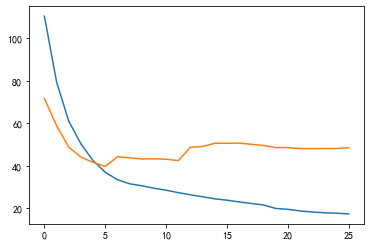

In [306]:
result = xgbr.evals_result()
plt.plot(result['validation_0']['rmse'])
plt.plot(result['validation_1']['rmse'])

### xgboost api

In [38]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

params = {'eta': 0.3,
          'objective': 'reg:squarederror',
          'gamma': 0,
          'max_depth': 5,
          'subsample': 0.5,
          'colsample_bytree': 1,
          'base_score': 0.5,
          'n_jobs': 8}

a = {}  # 记录验证集结果
model = xgb.train(params, dtrain, 300, early_stopping_rounds=20, evals=[
                  (dtest, 'test')], evals_result=a, verbose_eval=True)

[0]	test-rmse:787.05859
[1]	test-rmse:605.59271
[2]	test-rmse:535.71790
[3]	test-rmse:504.41638
[4]	test-rmse:451.57785
[5]	test-rmse:416.67691
[6]	test-rmse:368.91260
[7]	test-rmse:337.75443
[8]	test-rmse:336.24973
[9]	test-rmse:334.07410
[10]	test-rmse:320.31738
[11]	test-rmse:320.45258
[12]	test-rmse:305.20642
[13]	test-rmse:285.16476
[14]	test-rmse:286.65512
[15]	test-rmse:284.19476
[16]	test-rmse:284.05826
[17]	test-rmse:283.70371
[18]	test-rmse:279.53226
[19]	test-rmse:281.19687
[20]	test-rmse:277.47406
[21]	test-rmse:278.99527
[22]	test-rmse:273.31439
[23]	test-rmse:263.51685
[24]	test-rmse:261.43713
[25]	test-rmse:255.99350
[26]	test-rmse:256.36807
[27]	test-rmse:255.47286
[28]	test-rmse:254.09540
[29]	test-rmse:256.87180
[30]	test-rmse:258.02121
[31]	test-rmse:252.14825
[32]	test-rmse:259.23050
[33]	test-rmse:261.94702
[34]	test-rmse:259.51361
[35]	test-rmse:260.83997
[36]	test-rmse:257.71121
[37]	test-rmse:259.52267
[38]	test-rmse:266.07889
[39]	test-rmse:259.49432
[40]	test-

## 测试

### sklearn api

In [315]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate, KFold

In [312]:
tss = TimeSeriesSplit(n_splits=5)

In [316]:
kf = KFold(n_splits=5, shuffle=False)
cross_val_score(xgbr, x_train, y_train, cv=kf)

array([ 0.8206395 , -1.58494992, -0.56711028,  0.62549387, -0.36252929])

In [314]:
cross_val_score(xgbr, x_train, y_train)

array([ 0.8206395 , -1.58494992, -0.56711028,  0.62549387, -0.36252929])

In [317]:
cross_val_score(xgbr, x_train, y_train, cv=tss)

array([ 0.01076388, -0.06935506,  0.11217521, -0.91776087, -0.28840475])

In [324]:
x = np.random.randn(5, 5)
tss = TimeSeriesSplit(n_splits=2)

In [325]:
for i in tss.split(x):
    print(i)

(array([0, 1, 2]), array([3]))
(array([0, 1, 2, 3]), array([4]))


In [307]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.823
metrics2: 0.723
r2: -0.601


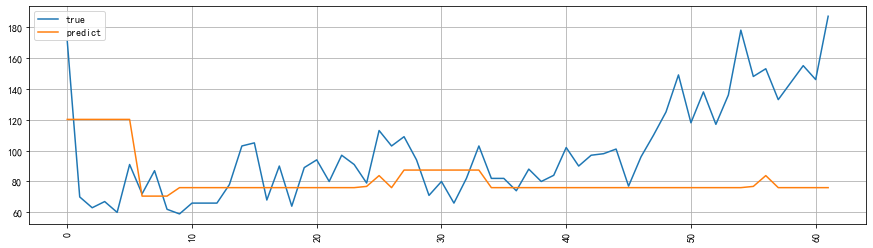

In [309]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend(fontsize=10)

In [298]:
a = xgbr.get_booster().get_score(importance_type='gain')
# len(a)
a

{'x6_50': 96440.584784,
 'x6_51': 55314.69544838461,
 'x6_49': 21758.675631916667,
 'x6_41': 9517.674958,
 'x2_3': 9070.514709480001,
 'x6_52': 19232.62240157143,
 'x6_34': 5839.107979250001,
 'x0_388': 13105.310223,
 'x0_116': 433.53125,
 'x0_112': 393.234375,
 'x0_308': 494.915039,
 'x3_7': 783.4363403333333,
 'x3_6': 4325.79966525,
 'x2_12': 306682.0675025,
 'x2_9': 5469.150941999999,
 'x0_364': 4626.642382749998,
 'x6_21': 4336.71118,
 'x6_35': 3256.543275,
 'x4_3': 1131.5224944572726,
 'x3_20': 332.2601115,
 'x1_2021': 1512.8368935750002,
 'x0_113': 903.257813,
 'x3_26': 581.4436035,
 'x0_476': 10.4296875,
 'x6_39': 2246.0030300000003,
 'x3_19': 464.4187266666667,
 'x0_284': 453.891602,
 'x6_53': 9693.544576857143,
 'x0_29': 10314.667529999999,
 'x0_384': 8948.214349857144,
 'x1_2019': 8169.326064,
 'x5_4': 14475.312870125,
 'x6_20': 2089.57705775,
 'x2_6': 5878.002398507501,
 'x6_14': 1710.693585,
 'x6_13': 3772.09375,
 'x1_2020': 2663.6289874147055,
 'x6_23': 430.50962333333337,

In [226]:
['f'+str(i) for i in list(range(1100))][999:-1]

['f999',
 'f1000',
 'f1001',
 'f1002',
 'f1003',
 'f1004',
 'f1005',
 'f1006',
 'f1007',
 'f1008',
 'f1009',
 'f1010',
 'f1011',
 'f1012',
 'f1013',
 'f1014',
 'f1015',
 'f1016',
 'f1017',
 'f1018',
 'f1019',
 'f1020',
 'f1021',
 'f1022',
 'f1023',
 'f1024',
 'f1025',
 'f1026',
 'f1027',
 'f1028',
 'f1029',
 'f1030',
 'f1031',
 'f1032',
 'f1033',
 'f1034',
 'f1035',
 'f1036',
 'f1037',
 'f1038',
 'f1039',
 'f1040',
 'f1041',
 'f1042',
 'f1043',
 'f1044',
 'f1045',
 'f1046',
 'f1047',
 'f1048',
 'f1049',
 'f1050',
 'f1051',
 'f1052',
 'f1053',
 'f1054',
 'f1055',
 'f1056',
 'f1057',
 'f1058',
 'f1059',
 'f1060',
 'f1061',
 'f1062',
 'f1063',
 'f1064',
 'f1065',
 'f1066',
 'f1067',
 'f1068',
 'f1069',
 'f1070',
 'f1071',
 'f1072',
 'f1073',
 'f1074',
 'f1075',
 'f1076',
 'f1077',
 'f1078',
 'f1079',
 'f1080',
 'f1081',
 'f1082',
 'f1083',
 'f1084',
 'f1085',
 'f1086',
 'f1087',
 'f1088',
 'f1089',
 'f1090',
 'f1091',
 'f1092',
 'f1093',
 'f1094',
 'f1095',
 'f1096',
 'f1097',
 'f1098']

In [247]:
zipp = zip(['f'+str(i) for i in list(range(1200))],
           encoder.get_feature_names())

In [248]:
cc = dict(list(zipp))

In [249]:
for i in zipp:
    print(i)

In [250]:
cc['f110']

'x0_111'

In [227]:
bb

[('f1000', 30),
 ('f1049', 14),
 ('f1107', 13),
 ('f566', 12),
 ('f1052', 11),
 ('f363', 10),
 ('f1048', 10),
 ('f1050', 10),
 ('f1106', 9),
 ('f519', 9),
 ('f360', 9),
 ('f1047', 9),
 ('f520', 9),
 ('f1007', 9),
 ('f1090', 8),
 ('f999', 8),
 ('f1014', 7),
 ('f1038', 7),
 ('f381', 7),
 ('f1057', 7),
 ('f1051', 7),
 ('f1031', 7),
 ('f23', 7),
 ('f1105', 6),
 ('f1005', 6),
 ('f1097', 6),
 ('f1081', 6),
 ('f1011', 6),
 ('f388', 6),
 ('f1025', 6),
 ('f1023', 6),
 ('f1030', 6),
 ('f1104', 6),
 ('f1029', 6),
 ('f1053', 6),
 ('f19', 6),
 ('f1001', 6),
 ('f1100', 6),
 ('f366', 6),
 ('f377', 6),
 ('f383', 5),
 ('f1056', 5),
 ('f1095', 5),
 ('f1022', 5),
 ('f1036', 5),
 ('f378', 5),
 ('f27', 5),
 ('f382', 5),
 ('f1039', 5),
 ('f380', 5),
 ('f1054', 5),
 ('f395', 5),
 ('f1040', 5),
 ('f1003', 5),
 ('f231', 5),
 ('f1108', 4),
 ('f256', 4),
 ('f1020', 4),
 ('f1008', 4),
 ('f1055', 4),
 ('f43', 4),
 ('f327', 4),
 ('f371', 4),
 ('f1028', 4),
 ('f1024', 4),
 ('f1013', 4),
 ('f1062', 4),
 ('f5', 4),
 (

In [251]:
list(map(lambda x: cc[x[0]], bb))

['x1_2020',
 'x4_3',
 'x6_51',
 'x0_567',
 'x4_6',
 'x0_364',
 'x4_2',
 'x4_4',
 'x6_50',
 'x0_520',
 'x0_361',
 'x4_1',
 'x0_521',
 'x2_5',
 'x6_34',
 'x1_2019',
 'x2_12',
 'x3_24',
 'x0_382',
 'x6_1',
 'x4_5',
 'x3_17',
 'x0_24',
 'x6_49',
 'x2_3',
 'x6_41',
 'x6_25',
 'x2_9',
 'x0_389',
 'x3_11',
 'x3_9',
 'x3_16',
 'x6_48',
 'x3_15',
 'x5_1',
 'x0_20',
 'x1_2021',
 'x6_44',
 'x0_367',
 'x0_378',
 'x0_384',
 'x5_4',
 'x6_39',
 'x3_8',
 'x3_22',
 'x0_379',
 'x0_28',
 'x0_383',
 'x3_25',
 'x0_381',
 'x5_2',
 'x0_396',
 'x3_26',
 'x2_1',
 'x0_232',
 'x6_52',
 'x0_257',
 'x3_6',
 'x2_6',
 'x5_3',
 'x0_44',
 'x0_328',
 'x0_372',
 'x3_14',
 'x3_10',
 'x2_11',
 'x6_6',
 'x0_6',
 'x3_23',
 'x2_8',
 'x6_43',
 'x6_40',
 'x6_33',
 'x6_13',
 'x3_19',
 'x0_573',
 'x6_14',
 'x0_313',
 'x3_21',
 'x6_11',
 'x6_38',
 'x3_1',
 'x0_395',
 'x6_18',
 'x0_197',
 'x0_7',
 'x4_0',
 'x3_2',
 'x3_20',
 'x0_18',
 'x0_19',
 'x0_500',
 'x0_380',
 'x0_258',
 'x3_5',
 'x6_21',
 'x3_3',
 'x0_629',
 'x6_28',
 'x0_3

In [222]:
bb = sorted(a.items(), key=lambda x: x[1], reverse=True)

### xgboost api

In [35]:
dtest = xgb.DMatrix(x_test, y_test)

In [36]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.939
metrics2: 0.732
r2: 0.858


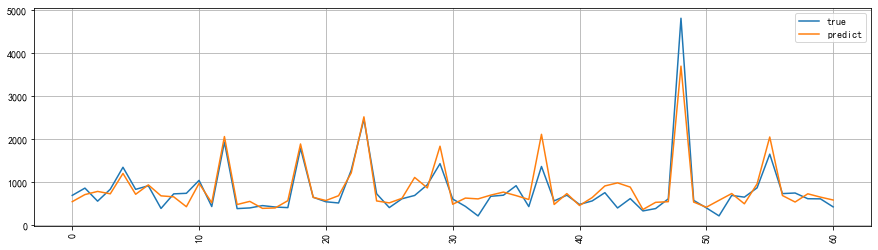

In [37]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [ ]:
model.get_score(importance_type='gain')

In [ ]:
xgb.to_graphviz(model, num_trees=0)

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [ ]:
model.feature_importances_.sum()

In [ ]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

In [ ]:
xgb.to_graphviz(model, num_trees=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)

In [ ]:
dt.fit(x, y)

In [ ]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [ ]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

In [ ]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())